In [1]:
import khmer
# ref = https://github.com/dib-lab/khmer/blob/master/examples/python-api/exact-counting.py
import tqdm
import pandas as pd
import numpy as np
import os, glob
import scanpy.api as sc
import anndata as ad
from scipy import sparse
from plotnine import *
import plotnine
from IPython.core.display import HTML

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

# filter completed samples
def find_completed (results_dir, dir_path, target_suffix):
    fa_list = []
    blastOut_list = []

    # check for completed files: *_geneCounts.csv
    for outfile in glob.glob(f'{results_dir}*/*_geneCounts.csv'):
        with open(outfile, 'r') as out_f:
            deduce_cell_id = outfile.split('/')[-2]
        deduce_target = f'{dir_path}{deduce_cell_id}{target_suffix}'
        deduce_out = f'{results_dir}{deduce_cell_id}/{deduce_cell_id}_blastpOut.txt'
        fa_list = fa_list + [deduce_target]
        blastOut_list = blastOut_list + [deduce_out]
    return fa_list, blastOut_list

def process_blastp_results(target_output, results_dir, evalue_cutoff):
    # ingest table
    results = pd.read_csv(target_output, 
                          sep = '\t',
                          header = None
                         )
    results.columns = ['qsid' , 'ssid', 'evalue']
    # parse frame and ids
    results['frame'] = [x.split('__')[-1][-1] for x in results['qsid']]
    results['qsid'] = [x.split('__')[0] for x in results['qsid']]
    results['uniprot'] = [x.split('|')[1] for x in results['ssid']]
    results['common_name'] = [x.split('|')[2] for x in results['ssid']]
    # return best-match frame
    results = results.sort_values('evalue', ascending = True).groupby(['qsid']).head(1)
    # filter results to significant matches
    results = results[results.evalue < evalue_cutoff]
    # adjust df to merge
    results = (results
               .loc[:,['uniprot','qsid']]
               .rename(columns = {'qsid':'seq_id'})
              )

    # ingest uniprot to symbol df for lookup
    scope2field_df = pd.read_csv(f'{results_dir}scope2field.csv',index_col = 0)
    results = pd.merge(scope2field_df,
                       results,
                       'inner',
                       'uniprot'
                      )
    results = results.drop('uniprot', axis = 1)
               
    return results


In [2]:
# look-up processed files for ingest
dir_path = '/home/ubuntu/data/longread/full_data/'
target_suffix = '.fa'
results_dir = '/home/ubuntu/data/longread/full_data/blast_results/'
fa_list, blastOut_list = find_completed (results_dir, dir_path, target_suffix)

# look up gene name for each read 
evalue_cutoff = 10
blastOut_table = pd.DataFrame()
for blastOut in blastOut_list:
    blastOut_slice = process_blastp_results(blastOut, results_dir, evalue_cutoff)
    blastOut_table = blastOut_table.append(blastOut_slice)

In [8]:
# kmerize
ksize = 7
nkmers = 4**ksize
read_n = 200

entry_len_list = []
for fn in fa_list:
    entry_len_list = entry_len_list+[int(file_len(fn)/2)]

entry_len_trimmed_list = [] 
for len_val in entry_len_list:
    if len_val < read_n:
        entry_len_trimmed_list = entry_len_trimmed_list+[len_val]
    else:
        entry_len_trimmed_list = entry_len_trimmed_list+[read_n]

balanced_entry_len_sum = np.sum(entry_len_trimmed_list)

cell_df = pd.DataFrame()
master_df = pd.DataFrame()
kmer_arr = np.zeros((nkmers, balanced_entry_len_sum))

arr_idx = 0
seq_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')
cell_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')

# ingest all .fa files from dir
for fn in fa_list:
    # extract fn prefix for cell id
    cell_id = fn.split('/')[-1].split('.fa')[0]

    # read .fa
    with open(fn, 'r') as f:

        # random downsample to sampling size
        for i, l in enumerate(f):
            pass

        entry_len = int((i+1)/2)
        if entry_len >= read_n:
            sample_n = read_n
        else:
            sample_n = entry_len
        np.random.seed(1)
        entry_white_list = np.random.choice([x*2 for x in range(entry_len)], 
                                            sample_n,
                                            replace = False,
                                           ).tolist()
        entry_white_list = [x+1 for x in entry_white_list]+entry_white_list

    with open(fn, 'r') as f:

        # parse entry by entry
        for count, line in tqdm.tqdm(enumerate(f, start=0)):

            # filter on whitelist
            if count in entry_white_list:

                # extract first line as seq id
                if count % 2 == 0:
                    k_name = line[1:-1]

                # extract second line as sequence
                if count % 2 != 0:

                    # Initialize countgraph
                    tablesize = nkmers + 10
                    ktable = khmer.Countgraph(ksize, tablesize, 1)

                    # count all k-mers in the given string
                    ktable.consume(line[:-1])

                    # capture full kmer counts
                    k_n_list = [ktable.get(i) for i in range(nkmers)]

                    # update kmer count arr
                    kmer_arr[:,arr_idx] = k_n_list 

                    # log sequence and cell names for metadata
                    seq_id_arr[arr_idx] = k_name
                    cell_id_arr[arr_idx] = cell_id

                    # update arr pointer
                    arr_idx = arr_idx + 1

# create dfs
kmers_list = [ktable.reverse_hash(i) for i in range(nkmers)]
master_df = pd.DataFrame(kmer_arr)
master_df['kmers'] = kmers_list
master_df = master_df.set_index('kmers')
master_df.columns = seq_id_arr.tolist()
master_df = master_df.astype(int)
cell_df = pd.DataFrame({'seq_id':seq_id_arr,
                        'cell_id':cell_id_arr,
                       })
cell_df = cell_df.set_index('seq_id')


7374it [00:01, 6900.91it/s]
15146it [00:01, 13772.09it/s]
14228it [00:01, 13141.27it/s]
59712it [00:01, 43022.48it/s]
11402it [00:01, 10911.44it/s]
8796it [00:01, 8735.34it/s]
10748it [00:01, 10464.12it/s]
18820it [00:01, 16944.36it/s]
13968it [00:01, 12808.73it/s]
3410it [00:01, 3266.83it/s]
6032it [00:01, 5627.56it/s]
11746it [00:01, 11360.70it/s]
3118it [00:00, 3173.15it/s]
17062it [00:01, 15763.64it/s]
4048it [00:01, 3900.50it/s]
390it [00:00, 410.13it/s]
38176it [00:01, 28940.87it/s]
9368it [00:01, 8555.35it/s] 
6058it [00:01, 5682.70it/s]
22486it [00:01, 18931.93it/s]
7562it [00:01, 7016.99it/s]
17858it [00:01, 16323.70it/s]
22364it [00:01, 19639.94it/s]
6410it [00:00, 6569.99it/s]
15676it [00:01, 14051.55it/s]
3540it [00:01, 3473.54it/s]
7200it [00:01, 6836.48it/s]
23588it [00:01, 19617.19it/s]
18506it [00:01, 15827.19it/s]
2508it [00:01, 2448.98it/s]
21742it [00:01, 18995.36it/s]
4312it [00:01, 4308.59it/s]
2362it [00:01, 2251.63it/s]
8022it [00:01, 7548.66it/s]
3026it [00:01, 

In [9]:
# ingest data to adata obj

# pd df to np array
array_adata = master_df.values

# extract obs and var
obs = master_df.columns.tolist()
gene_names = master_df.index.tolist()

# create ad obj
adata = ad.AnnData(X=array_adata).T
adata.X = sparse.csr_matrix(adata.X)
adata.var_names = gene_names
adata.obs_names = obs

# append metadata
adata.obs['cell_id'] = cell_df.cell_id.tolist()

# transform and freeze raw state
adata.raw = sc.pp.log1p(adata, copy=True)

# embed and cluster
n_pcs = 30
n_neighbs = 15
min_dist = 0.5

all_forms_adata = sc.pp.log1p(adata, copy=True) 
sc.pp.scale(all_forms_adata) 
sc.tl.pca(all_forms_adata, use_highly_variable = False, n_comps=n_pcs, random_state=1) 
sc.pp.neighbors(all_forms_adata, n_pcs=n_pcs, n_neighbors = n_neighbs, random_state=1) 
sc.tl.umap(all_forms_adata, min_dist = min_dist, random_state=1)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/ubuntu/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 19 separate connected components using meta-embedding (experimental)
  n_components
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


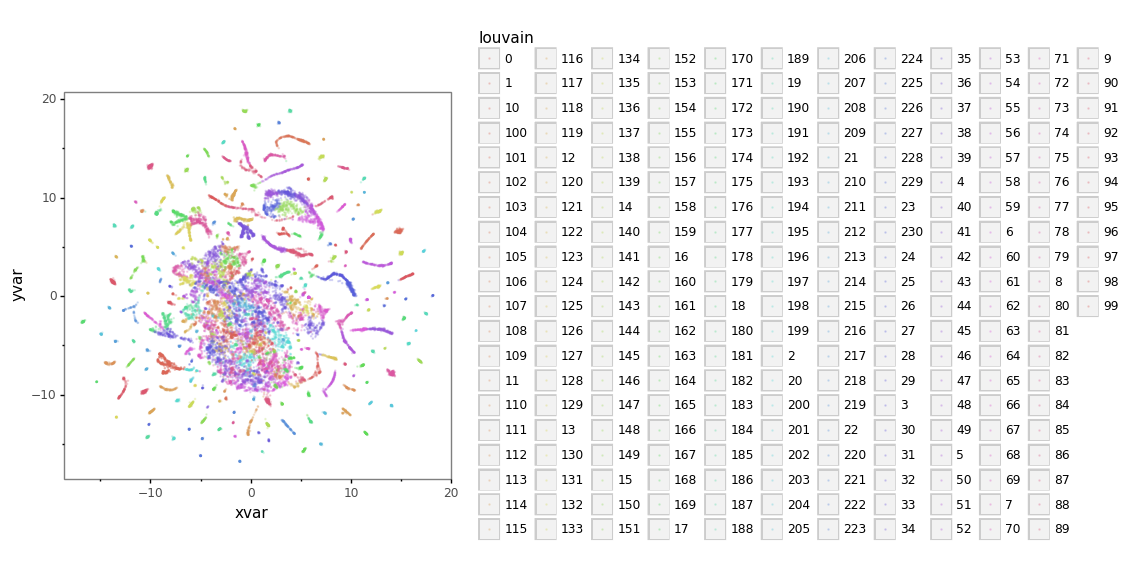

<ggplot: (8731795328383)>


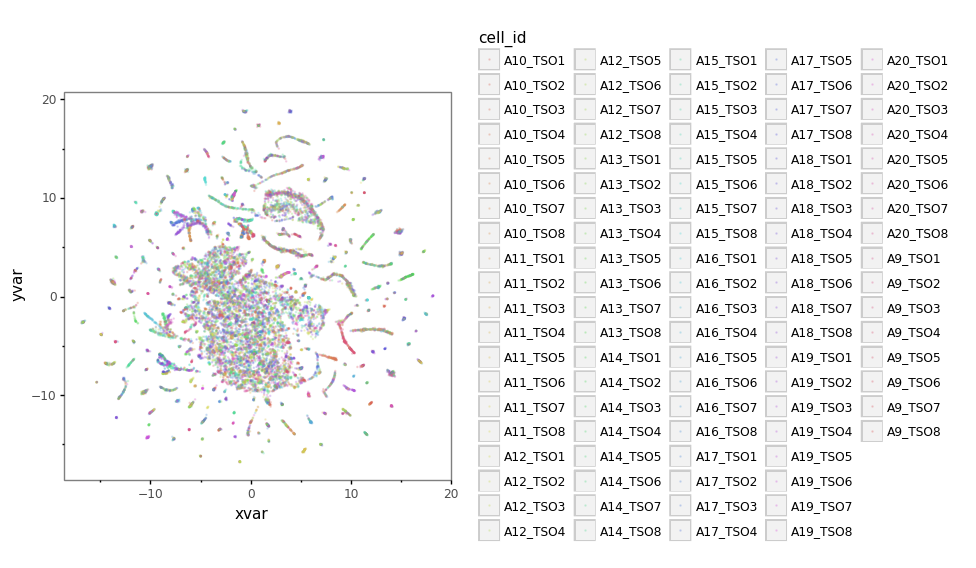

<ggplot: (8731624489024)>


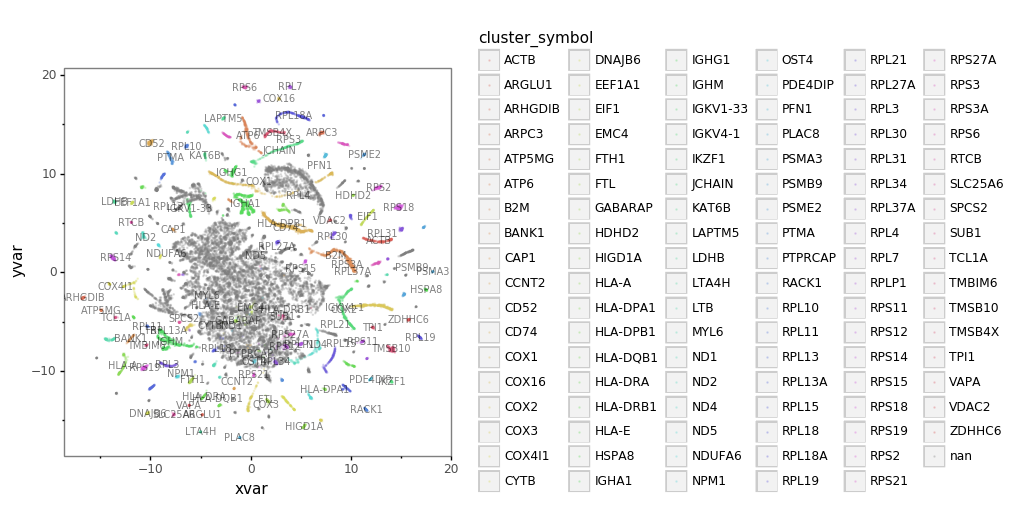

<ggplot: (8731794857529)>


In [10]:
louvain_res = 10
sc.tl.louvain(all_forms_adata, resolution = louvain_res, random_state=1)

umap_df = pd.DataFrame(all_forms_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['cell_id'] = all_forms_adata.obs.cell_id.tolist()
umap_df['seq_id'] = all_forms_adata.obs.index.tolist()
umap_df['louvain'] = all_forms_adata.obs.louvain.tolist()
# import gene symbols
umap_df = pd.merge(umap_df, blastOut_table, 'left', 'seq_id')
# assign clusters with symbols based on proportion of occupancy
c = (umap_df
     .loc[:,['louvain','symbol']]
     .replace(np.nan, 'UND')
     .groupby(['louvain'])['symbol']
     .value_counts()
     .rename("proportion")
    )
rename_df = (pd.DataFrame(c/c.groupby(level=0).sum())
             .sort_values('proportion', ascending = False)
             .reset_index()
             .rename(columns = {'symbol':'cluster_symbol'})
            )
rename_df = (rename_df[rename_df.proportion > 0.5]
             .replace('UND', np.nan)
             .dropna()
            )
umap_df = pd.merge(umap_df, rename_df, 'left', 'louvain')
label_df = (umap_df
            .loc[:,['xvar','yvar','cluster_symbol']]
            .groupby('cluster_symbol')
            .mean()
            .reset_index()
           )
plotnine.options.figure_size = (5,5)
for val in ['louvain','cell_id','cluster_symbol']:
    plot = (ggplot(umap_df)
            + theme_bw()
            + theme(aspect_ratio = 1,
                    panel_grid_major = element_blank(), 
                    panel_grid_minor = element_blank()
                   )
            + geom_point(aes('xvar','yvar',color=val), 
                         size=0.05,
                         alpha = 0.2)

           )
    if val == 'cluster_symbol':
        plot = (plot
                + geom_text(label_df, aes('xvar','yvar',label='cluster_symbol'), 
                        size = 7,
                        alpha = 0.5
                       )
               )
    print(plot)


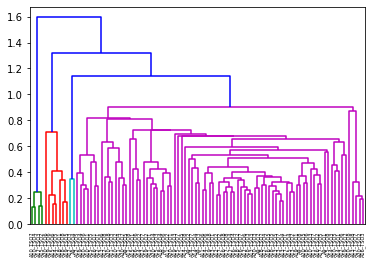

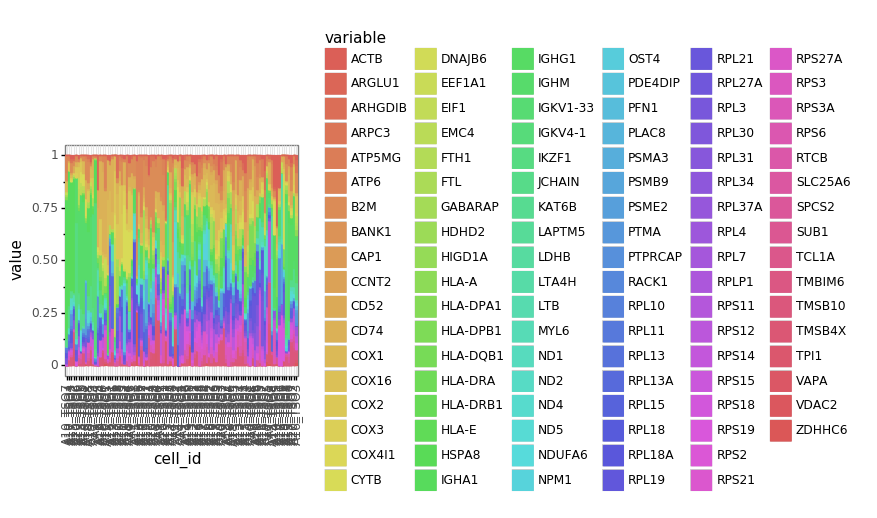

<ggplot: (-9223363305073650772)>


In [13]:
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from pandas.api.types import CategoricalDtype, is_categorical_dtype


### gene clustering
n_clust = 4
gois = list(set(label_df.cluster_symbol))
cluster_df = (pd.pivot(pd.DataFrame(umap_df[[x in gois for x in umap_df.cluster_symbol]]
                                 .groupby('cell_id')['cluster_symbol']
                                 .value_counts()
                                )
                     .rename(columns={'cluster_symbol':'count'})
                     .reset_index(),
                     index='cell_id', columns='cluster_symbol', values='count'
                    )
             .replace(np.nan,0)
             .astype(int)
            )
cell_ids = cluster_df.index.tolist()
marker_genes = cluster_df.columns.tolist()

cluster_df = pd.DataFrame(cluster_df.values/cluster_df.values.sum(axis=1, keepdims=True))
data = cluster_df.values


# scale
# data = StandardScaler().fit_transform(data)
# scaled_data = pd.DataFrame(data, columns=marker_genes)
    
# clustering
Z = hierarchy.linkage(data, 'ward', optimal_ordering=True)
cutree = hierarchy.cut_tree(Z, n_clusters=[n_clust])
labels = cutree.flatten().tolist()
dn = hierarchy.dendrogram(Z, 
                          labels=cell_ids,
                          distance_sort=True
                         )
labels = [f'cluster_{x}' for x in labels]
cluster_df.columns = marker_genes
cluster_df['cell_id'] = cell_ids
cluster_df['label'] = labels
index_order = dn['ivl']

plot_df = pd.melt(cluster_df, id_vars=['cell_id','label'])
plot_df['cell_id'] = (plot_df['cell_id']
                      .astype(str)
                      .astype(CategoricalDtype(index_order, ordered = True))
                     )

plot = (ggplot(plot_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90))
        + geom_bar(aes('cell_id','value', 
                       fill='variable',
                       color='variable'
                      ), stat='identity')
       )
print(plot)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 258 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


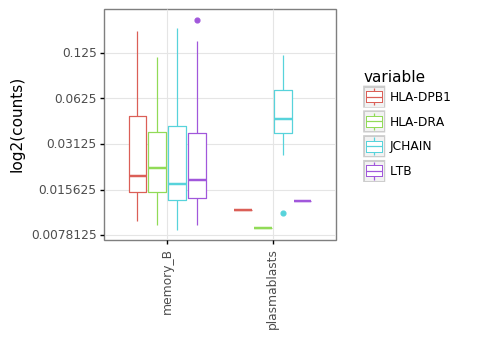

<ggplot: (-9223363305073551556)>


In [14]:
plot_df = pd.melt(cluster_df.loc[:,['JCHAIN','LTB','HLA-DRA','HLA-DPB1','label']], id_vars = 'label')
plot_df['label'] = ['plasmablasts' if x != 'cluster_0' else 'memory_B' for x in plot_df['label']]
plotnine.options.figure_size=(3,3)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle=90))
        + geom_boxplot(aes('label','value',color='variable'))
        + scale_y_continuous(trans='log2')
        + labs(x = '', y = 'log2(counts)')
       )
print(plot)

# recluster gene cloud to determine isoforms

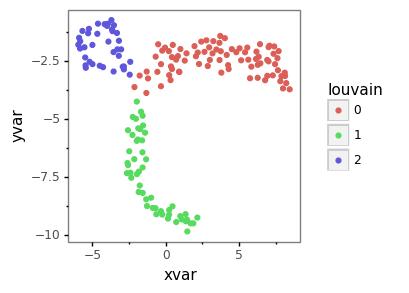

<ggplot: (8731795611340)>


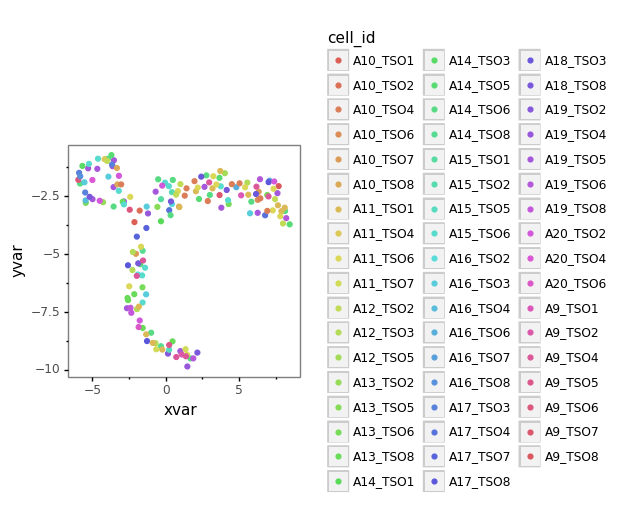

<ggplot: (-9223363305071001719)>


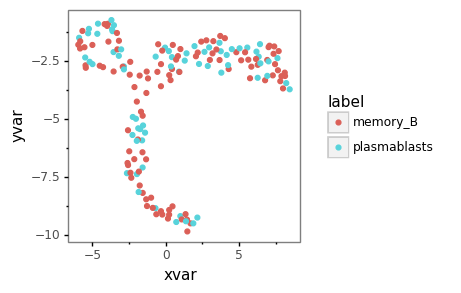

<ggplot: (-9223363305061210687)>


In [39]:
n_pcs = 10
n_neighbs = 10
min_dist = 0.4
louvain_res = 0.2

target_cluster_reads = umap_df[umap_df.cluster_symbol == 'JCHAIN'].seq_id.tolist()
recluster_adata = sc.pp.log1p(adata[[x in target_cluster_reads for x in adata.obs.index]], 
                              copy=True) 
sc.pp.scale(recluster_adata) 
sc.tl.pca(recluster_adata, use_highly_variable = False, n_comps=n_pcs, random_state=1) 
sc.pp.neighbors(recluster_adata, n_pcs=n_pcs, n_neighbors = n_neighbs, random_state=1) 
sc.tl.umap(recluster_adata, min_dist = min_dist, random_state=1)
sc.tl.louvain(recluster_adata, resolution = louvain_res, random_state=1)

rc_umap_df = pd.DataFrame(recluster_adata.obsm['X_umap'], columns = ['xvar','yvar'])
rc_umap_df['cell_id'] = recluster_adata.obs.cell_id.tolist()
rc_umap_df['louvain'] = recluster_adata.obs.louvain.tolist()
rc_umap_df['label'] = ['plasmablasts' if x in cluster_df[cluster_df.label != 'cluster_0'].cell_id.tolist() \
                         else 'memory_B' for x in rc_umap_df['cell_id']
                        ]

for col_val in ['louvain','cell_id','label']:
    plot = (ggplot(rc_umap_df)
                + theme_bw()
                + theme(aspect_ratio = 1,
                        panel_grid_major = element_blank(), 
                        panel_grid_minor = element_blank()
                       )
                + geom_point(aes('xvar','yvar',color=col_val))
               )
    print(plot)


In [ ]:
# def process_fasta (infile, filter_list, outfile):
#     with open(infile, 'r') as f:
#         sublines = []
#         entry_name = ''
#         for idx,line in enumerate(f):
#             line = line[:-1]
#             if line.startswith('>') and entry_name == '':
#                 entry_name = line
#             if line.startswith('>') and entry_name != '':
#                 if len(sublines) > 0 and entry_name in filter_list:
#                     print_seq = ''.join(sublines)
#                     ### process entry seq
#                     with open(outfile, 'a') as outf:
#                         outf.write(f'{entry_name}\n')
#                         outf.write(f'{print_seq}\n')
#                     ###
#                     sublines = []
                
#                 else:
#                     sublines = []
#                 entry_name = line 
#             else:
#                 sublines = sublines+[line]
#         if len(sublines) > 0 and entry_name in filter_list:
#             print_seq = ''.join(sublines)
#             ### process entry seq
#             with open(outfile, 'a') as outf:
#                 outf.write(f'{entry_name}\n')
#                 outf.write(f'{print_seq}\n')
#             ###


In [ ]:
# try:
#     os.remove('/home/ubuntu/data/longread/test_dir/msa.fa')
# except:
#     pass

# input_df = umap_df[umap_df.symbol == 'IGHM']
# for cell_id in tqdm.tqdm(set(input_df.cell_id)):
    
#     print(cell_id)
#     cellid_slice = input_df[input_df.cell_id == cell_id]
#     seq_list = [f'>{x}' for x in cellid_slice.seq_id.tolist()]
#     process_fasta (f'{dir_path}{cell_id}{target_suffix}', 
#                    seq_list, 
#                    '/home/ubuntu/data/longread/test_dir/msa.fa')

# ! cat /home/ubuntu/data/longread/test_dir/msa.fa | head

In [ ]:
# louvain = '28'
# umap_df['highlight'] = [x == louvain for x in umap_df.louvain]

# plotnine.options.figure_size = (5,5)
# plot = (ggplot(umap_df)
#         + theme_bw()
#         + theme(aspect_ratio = 1,
#                 panel_grid_major = element_blank(), 
#                 panel_grid_minor = element_blank()
#                )
#         + geom_point(aes('xvar','yvar',color='highlight'), size=0.1)
#        )
# print(plot)

# cluster_slice = umap_df[umap_df.highlight == True].loc[:,['cell_id','symbol','cluster_symbol','louvain']]
# display(cluster_slice.sort_values('symbol'))


In [ ]:
pcx = 2
pcy = pcx+1
pca_df = pd.DataFrame(all_forms_adata.obsm['X_pca'][:,[pcx, pcy]], columns = ['xvar','yvar'])
pca_df['cell_id'] = all_forms_adata.obs.cell_id.tolist()
pca_df['seq_id'] = all_forms_adata.obs.index.tolist()
pca_df['louvain'] = all_forms_adata.obs.louvain.tolist()
# import gene symbols
pca_df = pd.merge(pca_df, blastOut_table, 'left', 'seq_id')
# assign clusters with symbols based on proportion of occupancy
c = (pca_df
     .loc[:,['louvain','symbol']]
     .replace(np.nan, 'UND')
     .groupby(['louvain'])['symbol']
     .value_counts()
     .rename("proportion")
    )
rename_df = (pd.DataFrame(c/c.groupby(level=0).sum())
             .sort_values('proportion', ascending = False)
             .reset_index()
            )
rename_df = (rename_df[~rename_df['louvain'].duplicated('first')].
             rename(columns = {'symbol':'cluster_symbol'})
            )
pca_df = pd.merge(pca_df, rename_df, 'left', 'louvain')
# create labels
label_df = (pca_df
            .loc[:,['xvar','yvar','cluster_symbol']]
            .groupby('cluster_symbol')
            .mean()
            .reset_index()
           )

plotnine.options.figure_size = (5,5)
for val in ['louvain','cell_id','cluster_symbol']:
    plot = (ggplot(pca_df)
            + theme_bw()
            + theme(aspect_ratio = 1,
                    panel_grid_major = element_blank(), 
                    panel_grid_minor = element_blank()
                   )
            + geom_point(aes('xvar','yvar',color=val), 
                         size=0.05,
                         alpha = 0.2)
            + geom_text(label_df, aes('xvar','yvar',label='cluster_symbol'), 
                        size = 7,
                        alpha = 0.5
                       )
           )
    print(plot)

# kmerize by cell

In [12]:
### k-merize on reads
### take mean of kmer per cell
### cluster

fa_list = glob.glob('/home/ubuntu/data/longread/full_data/*.fa')
ksize = 6
nkmers = 4**ksize

master_df = pd.DataFrame()

# ingest all .fa files from dir
for fn in tqdm.tqdm(fa_list):
    # extract fn prefix for cell id
    cell_id = fn.split('/')[-1].split('.fa')[0]
    
    # get line count and set results arr
    with open(fn, 'r') as f:
        for count, line in enumerate(f, start=0):
            pass
    kmer_arr = np.zeros((nkmers, count))

    # read .fa
    with open(fn, 'r') as f:
        # parse entry by entry
        arr_idx = 0
        for count, line in enumerate(f, start=0):

            # extract second line as sequence
            if count % 2 != 0:

                # Initialize countgraph
                tablesize = nkmers + 10
                ktable = khmer.Countgraph(ksize, tablesize, 1)

                # count all k-mers in the given string
                ktable.consume(line[:-1])

                # capture full kmer counts
                k_n_list = [ktable.get(i) for i in range(nkmers)]

                # update kmer count arr
                kmer_arr[:,arr_idx] = k_n_list 

                # update arr pointer
                arr_idx = arr_idx + 1
    
    cell_slice = pd.DataFrame({cell_id:kmer_arr.mean(axis=1).tolist()})
    master_df = pd.concat([master_df, cell_slice], axis=1)
    

# create dfs
kmers_list = [ktable.reverse_hash(i) for i in range(nkmers)]
master_df['kmers'] = kmers_list
master_df = master_df.set_index('kmers')
master_df = master_df.astype(int)


100%|██████████| 96/96 [11:36<00:00, 11.98s/it]


In [27]:
# ingest data to adata obj

# pd df to np array
array_adata = master_df.values

# extract obs and var
obs = master_df.columns.tolist()
gene_names = master_df.index.tolist()

# create ad obj
adata = ad.AnnData(X=array_adata).T
adata.X = sparse.csr_matrix(adata.X)
adata.var_names = gene_names
adata.obs_names = obs

# transform and freeze raw state
adata.raw = sc.pp.log1p(adata, copy=True)

# embed and cluster
n_pcs = 15
n_neighbs = 10
min_dist = 0.2

all_forms_adata = sc.pp.log1p(adata, copy=True) 
sc.pp.scale(all_forms_adata) 
sc.tl.pca(all_forms_adata, use_highly_variable = False, n_comps=n_pcs, random_state=1) 
sc.pp.neighbors(all_forms_adata, n_pcs=n_pcs, n_neighbors = n_neighbs, random_state=1) 
sc.tl.umap(all_forms_adata, min_dist = min_dist, random_state=1)


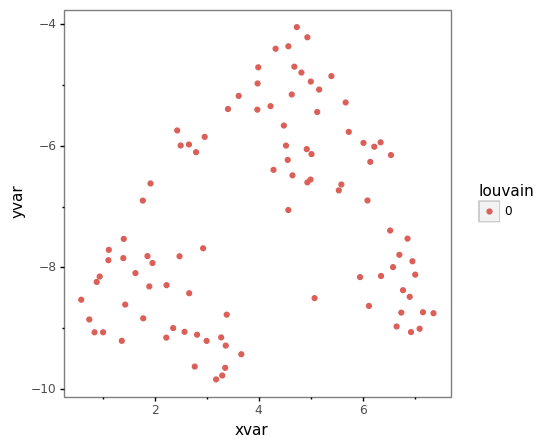

<ggplot: (-9223363251693482955)>


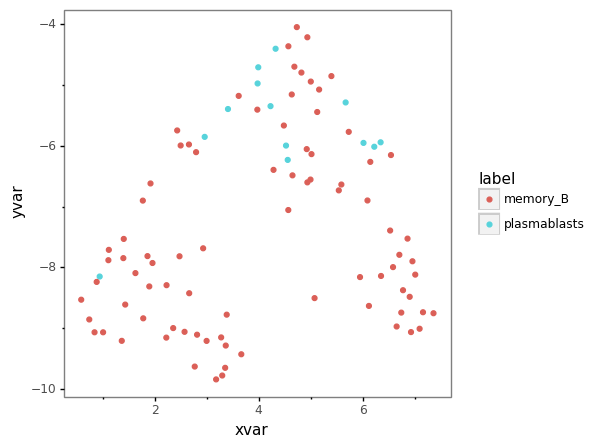

<ggplot: (-9223363251693967174)>


In [28]:
louvain_res = 0.1
sc.tl.louvain(all_forms_adata, resolution = louvain_res, random_state=1)

# pcx = 2
# pcy = pcx+1
# pca_df = pd.DataFrame(all_forms_adata.obsm['X_pca'][:,[pcx, pcy]], columns = ['xvar','yvar'])
# pca_df['louvain'] = all_forms_adata.obs.louvain.tolist()

umap_df = pd.DataFrame(all_forms_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['louvain'] = all_forms_adata.obs.louvain.tolist()
umap_df['cell_id'] = all_forms_adata.obs.index.tolist()
umap_df['label'] = ['plasmablasts' if x in cluster_df[cluster_df.label != 'cluster_0'].cell_id.tolist() \
                         else 'memory_B' for x in umap_df['cell_id']
                        ]

plotnine.options.figure_size = (5,5)
for val in ['louvain','label']:
    plot = (ggplot(umap_df)
            + theme_bw()
            + theme(aspect_ratio = 1,
                    panel_grid_major = element_blank(), 
                    panel_grid_minor = element_blank()
                   )
            + geom_point(aes('xvar','yvar',color=val))
           )
    print(plot)
